In [1]:
import dionysus as d
import matplotlib.pyplot as plt

aux_zz = []
all_generator_list = []
f = []


def vertexNumber(row,colum,numCols):
    return row*numCols+colum

def containsList (l2,l1):
    return(l1 in l2)


def addWithoutRepetition (s, l):
    if not containsList (l,s):
        l.append(s)

def binaryImageToSimplicialComplexList(img):
    rowNum = img.shape[0]
    colNum = img.shape[1]
    simplices0 = []
    simplices1 =[]
    simplices2 = []
    for j in range(0,rowNum):
        for i in range(0,colNum):
            if (img[j][i]==255):
                v = vertexNumber(j,i,colNum)
                addWithoutRepetition([v],simplices0)
                if (j < rowNum-1) and (img[j+1,i] == 255):
                    v10 = vertexNumber(j+1,i,colNum)
                    addWithoutRepetition([v10],simplices0)
                    addWithoutRepetition([v,v10],simplices1)
                if (i < colNum-1) and (img[j,i+1] == 255):
                    v01 = vertexNumber(j,i+1,colNum)
                    addWithoutRepetition([v01],simplices0)
                    addWithoutRepetition([v,v01],simplices1)
                    if (j < rowNum-1) and (img[j+1,i] == 255):
                        addWithoutRepetition([v01,v10],simplices1)
                        simplices2.append([v,v01,v10])
                        if (img[j+1,i+1] == 255):
                            v11 = vertexNumber(j+1,i+1,colNum)
                            addWithoutRepetition([v11],simplices0)
                            addWithoutRepetition([v01,v11],simplices1)
                            addWithoutRepetition([v10,v11],simplices1)
                            simplices2.append([v01,v10,v11])
                if (i < colNum-1) and (j < rowNum-1) and (img[j+1,i+1] == 255):
                    v11 = vertexNumber(j+1,i+1,colNum)
                    addWithoutRepetition([v11],simplices0)
                    if (img[j,i+1]==0) or (img[j+1,i]==0):
                        addWithoutRepetition([v,v11],simplices1)
                    if (img[j,i+1] == 255):                        
                        if (img[j+1,i]!=255):
                            addWithoutRepetition([v01,v11],simplices1)
                            addWithoutRepetition([v,v01,v11],simplices2)
                    if (img[j+1,i] == 255):
                        if (img[j,i+1]!=255):
                            addWithoutRepetition([v10,v11],simplices1)
                            addWithoutRepetition([v,v10,v11],simplices2)
                if (i >0) and (j < rowNum-1) and (img[j+1,i-1] == 255):
                    v1_1 = vertexNumber(j+1,i-1,colNum)
                    addWithoutRepetition([v1_1],simplices0)
                    
                    addWithoutRepetition([v,v1_1],simplices1)
                    if (img[j+1,i]==255):
                        addWithoutRepetition([v1_1,v10],simplices1)
                        addWithoutRepetition([v,v1_1,v10],simplices2)
    simplices0 = sorted(simplices0, key=lambda x: (x[0]))
    simplices1 = sorted(simplices1, key=lambda x: (x[0],x[1]))
    simplices2 = sorted(simplices2, key=lambda x: (x[0],x[1],x[2]))
    return simplices0,simplices1,simplices2

def binaryImageToSimplicialComplex(img):
    simplices0,simplices1,simplices2 = binaryImageToSimplicialComplexList(img)
    return simplices0+simplices1+simplices2


def simplicialComplexListToZigzagFiltration(sclist):
    total_simplices_l = []
    indices_l = []
    previous_simplices_l = []
    
    for i,sc in enumerate(sclist):
        for s in sc:
            if containsList(total_simplices_l,s) :
                if not containsList(previous_simplices_l,s):
                    index = total_simplices_l.index(s)
                    indices_l[index].append(i)          
            else:
                total_simplices_l.append(s)
                indices_l.append([i])
        for s in previous_simplices_l:
            if not containsList(sc,s):
                index = total_simplices_l.index(s)
                indices_l[index].append(i)
        previous_simplices_l = sc
    return total_simplices_l,indices_l


def detail(i,t,d,zz,cells):
    global aux_zz
    global all_generator_list, f
    
    aux_zz = []  
    for z in zz:
        aux_zz.append(z)        
    if len(aux_zz)!=0:
        aux_zz_last = aux_zz[len(aux_zz)-1]
    else:
        aux_zz_last = []
    z_list = []
    for x in aux_zz_last:
        z_list.append([x.element, f[cells[x.index]]])
    all_generator_list.append(z_list)
    
    
def scListZigzagHomology(times):
    global aux_zz
    global all_generator_list, f
                                                    
    aux_zz = []
    all_generator_list = []

    zz, dgms, cells = d.zigzag_homology_persistence(f, times  , callback = detail)
    return dgms, all_generator_list 
    
        
def imageListZigzagHomology (imageList):
    global f
    l0 = []
    l1 = []
    l2 = []
    for img in imageList:
        sc0,sc1,sc2 = binaryImageToSimplicialComplexList(img)
        l0.append(sc0)
        l1.append(sc1)
        l2.append(sc2)
    zz_list0,zz_indices0 = simplicialComplexListToZigzagFiltration(l0)
    zz_list1,zz_indices1 = simplicialComplexListToZigzagFiltration(l1)
    zz_list2,zz_indices2 = simplicialComplexListToZigzagFiltration(l2)
    f = d.Filtration(zz_list0+zz_list1+zz_list2)
    times = zz_indices0 + zz_indices1 + zz_indices2
    return scListZigzagHomology(times)


def printGenerator (glist):
    return (' + '.join("%d * %s" % (pair[0], [v for v in pair[1]]) for pair in glist))


def plot_zigzag_bars(dgm, dimension, times, generator_list, interval_l=1, gen_l1=1, gen_l2=0, printGenerators=True,
                     order='birth', ax=None, **bar_style):
    """
    Plot the barcode.
    Arguments:
        dgm (Diagram): See for example `init_diagrams`.
    Keyword Arguments:
        order (str): How to sort the bars, either 'death' or 'birth'
                     (Default: 'birth')
        show (bool): Display the plot. (Default: False)
        ax (AxesSubplot): Axes that should be used for plotting (Default: None)
        **bar_style: Arguments passed to `ax.plot` for style of the bars.
                     (Defaults: color='b')
    """

    bar_kwargs = {'color': 'b'}
    bar_kwargs.update(bar_style)

    if order == 'death':
        generator = enumerate(sorted(dgm, key=lambda p: p.death))
    else:
        generator = enumerate(dgm)

    if ax is None:
        ax = plt.axes()

    maxi = max(times, key=max)
    maxi = maxi[len(maxi) - 1]

    ax.set_xlim(-0.5, maxi + 1.5)

    result_generators = []

    i = 0
    for j, p in generator:
        if p.death == float('inf'):
            de = maxi + 1
        else:
            de = p.death
        if de - p.birth >= interval_l:
            g = generator_list[p.data]
            if (gen_l1 <= len(g)) and (gen_l2 == 0 or len(g) <= gen_l2):
                if p.death == float('inf'):
                    ax.plot([p.birth, maxi + 1], [i, i], **bar_kwargs)
                    plt.scatter([p.birth], [i], color="blue", edgecolor="blue")
                    result_generators.append(printGenerator(generator_list[p.data]))
                    if printGenerators:
                        plt.text(p.birth, i + 0.2, printGenerator(generator_list[p.data]))
                else:
                    ax.plot([p.birth, p.death - 0.05], [i, i], **bar_kwargs)
                    plt.scatter([p.birth], [i], color="blue", edgecolor="blue")
                    plt.scatter([p.death], [i], color="white", edgecolor="blue")
                    result_generators.append(printGenerator(generator_list[p.data]))
                    if printGenerators:
                        plt.text(p.birth, i + 0.2, printGenerator(generator_list[p.data]))
                i = i + 1

    plt.text(0, i - 0.2, "Barcode of dimension " + str(dimension))
    ax.set_ylim(-1, i)


    plt.show()



def imageListZigzagPlotBar (imageList,dimensions=[0,1],interval_l=1, gen_l1=1, gen_l2=0,printGenerators=True):
    global f
    l0 = []
    l1 = []
    l2 = []
    for img in imageList:
        sc0,sc1,sc2 = binaryImageToSimplicialComplexList(img)
        l0.append(sc0)
        l1.append(sc1)
        l2.append(sc2)
    zz_list0,zz_indices0 = simplicialComplexListToZigzagFiltration(l0)
    zz_list1,zz_indices1 = simplicialComplexListToZigzagFiltration(l1)
    zz_list2,zz_indices2 = simplicialComplexListToZigzagFiltration(l2)
    f = d.Filtration(zz_list0+zz_list1+zz_list2)
    times = zz_indices0 + zz_indices1 + zz_indices2
    dgms, generator_list = scListZigzagHomology(times)
    
    for i in dimensions:
        dgm = dgms[i]
        plot_zigzag_bars(dgm, i, times, generator_list, interval_l, gen_l1, gen_l2,printGenerators)



## Example:

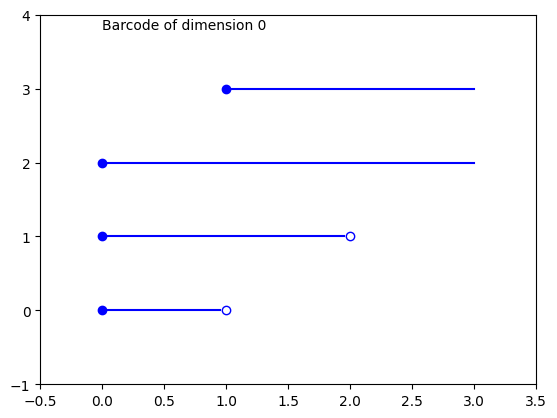

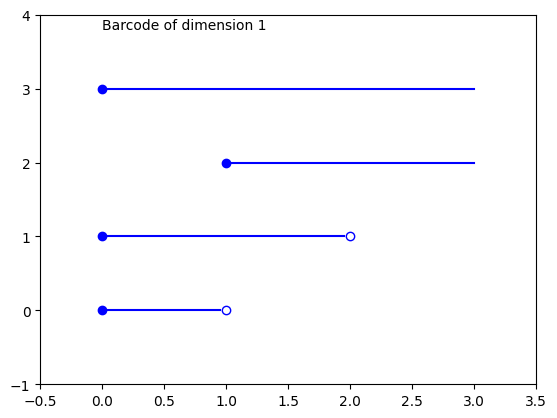

In [2]:
import cv2

img1 = cv2.imread("../examples/imagen1ByN.pbm",0)
img2 = cv2.imread("../examples/imagen2ByN.pbm",0)
img3 = cv2.imread("../examples/imagen3ByN.pbm",0)

imageListZigzagPlotBar([img1, img2, img3],dimensions=[0,1],interval_l=1,gen_l1=1,gen_l2=0,printGenerators = False)